In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
from shapely.geometry import LineString
from skimage import measure


# Sigma winter, sigma season ratio, 90th km, 99th km, 90th dd, 99th dd 

In [2]:

def find_plot_contour(self, ax_show , N_branch=60, offset_low = 1, offset_up=1, color = 'k', lstyle = '--', model_name = None):
    Z = self.norm_density.T
    # -- Branches
    Z_contour = np.copy(Z)
    # Z_contour[18:, 18:] = 1 ## this number actually depends on nd and nbpd and the general shape of the Y 
    cont = measure.find_contours(Z_contour, 1)
    N = N_branch
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = self._fit_branches(cont,N, offset_low, offset_up)
    x_branch_2 = y_branch_1 = np.linspace(5,N_branch,N_branch)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # Create line strings for intersection
    curve1 = LineString(np.column_stack((x_branch_1, y_branch_1)))
    curve2 = LineString(np.column_stack((x_branch_2, y_branch_2)))
    
    if ax_show is not False : 
        # show branches
        ax_show.plot(x_branch_1,y_branch_1, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5)
        ax_show.plot(x_branch_2,y_branch_2, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5, label  = model_name)

    return ax_show, curve1, curve2

Data loaded from /scratchx/mcarenso/tempest/UM_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/UM_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy
Data loaded from /scratchx/mcarenso/tempest/UM_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/UM_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy


Text(0.5, 1.0, 'Ratio of Winter $\\sigma_{0.25}$ over Summer $\\sigma_{0.25}$')

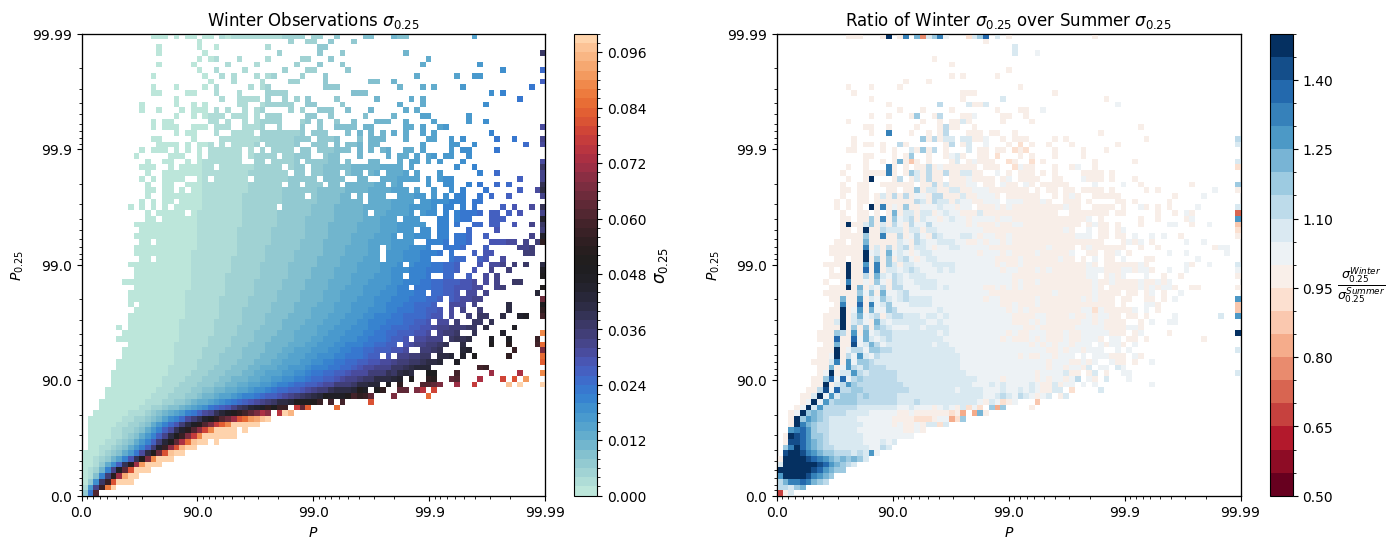

In [11]:
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.patheffects as path_effects
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union

settings_path = 'settings/um_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_winter = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = False, dist_mask = "all")

settings_path = 'settings/um_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_summer = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = False, dist_mask = "all")

fig, axs = plt.subplots(1, 2, figsize = (16.45, 6))
## left one
model_name = jd_winter.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.1+0.002, 0.002)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cb, ax_show_, sigma_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axs[0])
_, _, _, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = False)
axs[0].set_ylabel(r"$P_{0.25}$")
axs[0].set_xlabel(r"$P$")
cb.set_label(r"$\sigma_{0.25}$", fontsize=12)
axs[0].set_title("Winter Observations $\sigma_{0.25}$")

## Sigma ratio for explanation
cmap = sns.color_palette("RdBu", as_cmap=True)
values_and_boundaries = np.arange(0.5, 1.55, 0.05)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

obs_season_ratio_sigma_75 = sigma_density_obs_winter/sigma_density_obs_summer
ax, cb, ax_show, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist(
                                                    'Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axs[1], 
                                                    density=obs_season_ratio_sigma_75
                                                    )
axs[1].set_ylabel(r"$P_{0.25}$")
axs[1].set_xlabel(r"$P$")
# cb.set_label()
cb.ax.set_ylabel(r'$\frac{\sigma^{Winter}_{0.25}}{\sigma^{Summer}_{0.25}}$', fontsize=13, rotation = 0, labelpad = 20)

title = r"Ratio of Winter $\sigma_{0.25}$ over Summer $\sigma_{0.25}$"
axs[1].set_title(title)

# plot_kite(jd_summer, fig, ax_show)

/home/mcarenso/code/tempest/tempest/joint_distrib.py:464: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


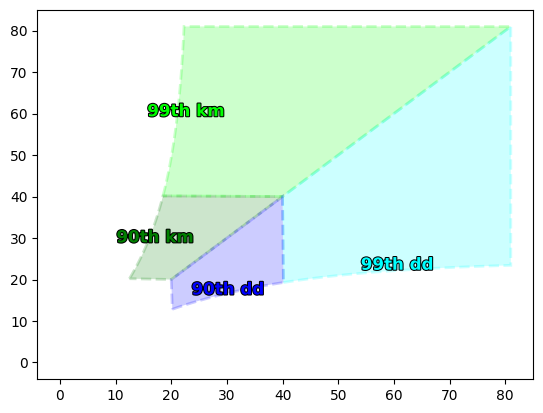

In [4]:
def plot_kite(jd, fig=None, ax=None):
    if fig is None : 
        fig, ax = plt.subplots(1, 1)
    # Plot the initial polygons
    ax.plot(0,0)

    _, curve1, curve2 = find_plot_contour(jd, ax_show = False, N_branch=81, offset_low = 1, offset_up=1, color = 'k', lstyle="--", model_name = model_name+" Summer")

    curve1_coords = np.array(curve1.coords)

    km90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    km90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km90_vertices.append((40, 40))  
    km90_vertices.append((20, 20))  

    km99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-81))
    km99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km99_vertices.append((81, 81))  
    km99_vertices.append((40, 40))  

    curve1_coords = np.array(curve2.coords)

    dd90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    dd90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd90_vertices.append((40, 40))  
    dd90_vertices.append((20, 20))  

    dd99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-81))
    dd99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd99_vertices.append((81, 81))  
    dd99_vertices.append((40, 40))  

    polygons = [
        (km90_vertices, 'green', '90th km'),
        (km99_vertices, 'lime', '99th km'),
        (dd99_vertices, 'cyan', '99th dd'),
        (dd90_vertices, 'blue', '90th dd')
    ]

    # Create a new patch with the constructed vertices
    for vertices, color, label in polygons:
        polygon = MplPolygon(vertices, closed=True, edgecolor=color, facecolor=color, linewidth=2, linestyle='--', alpha=0.2)
        ax.add_patch(polygon)
        
        # Calculate approximate center for text placement
        x_coords, y_coords = zip(*vertices)
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        
        # Add text annotation
        text = ax.text(center_x, center_y, label, color=color, fontsize=12, ha='center', va='center', weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
    
    return None
plot_kite(jd_summer)

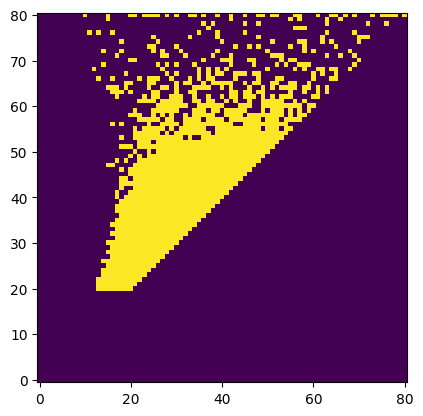

In [157]:
plt.imshow(jd_summer.mask_coloc_c_90.T, origin = "lower")

# Compare 2Ds

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy


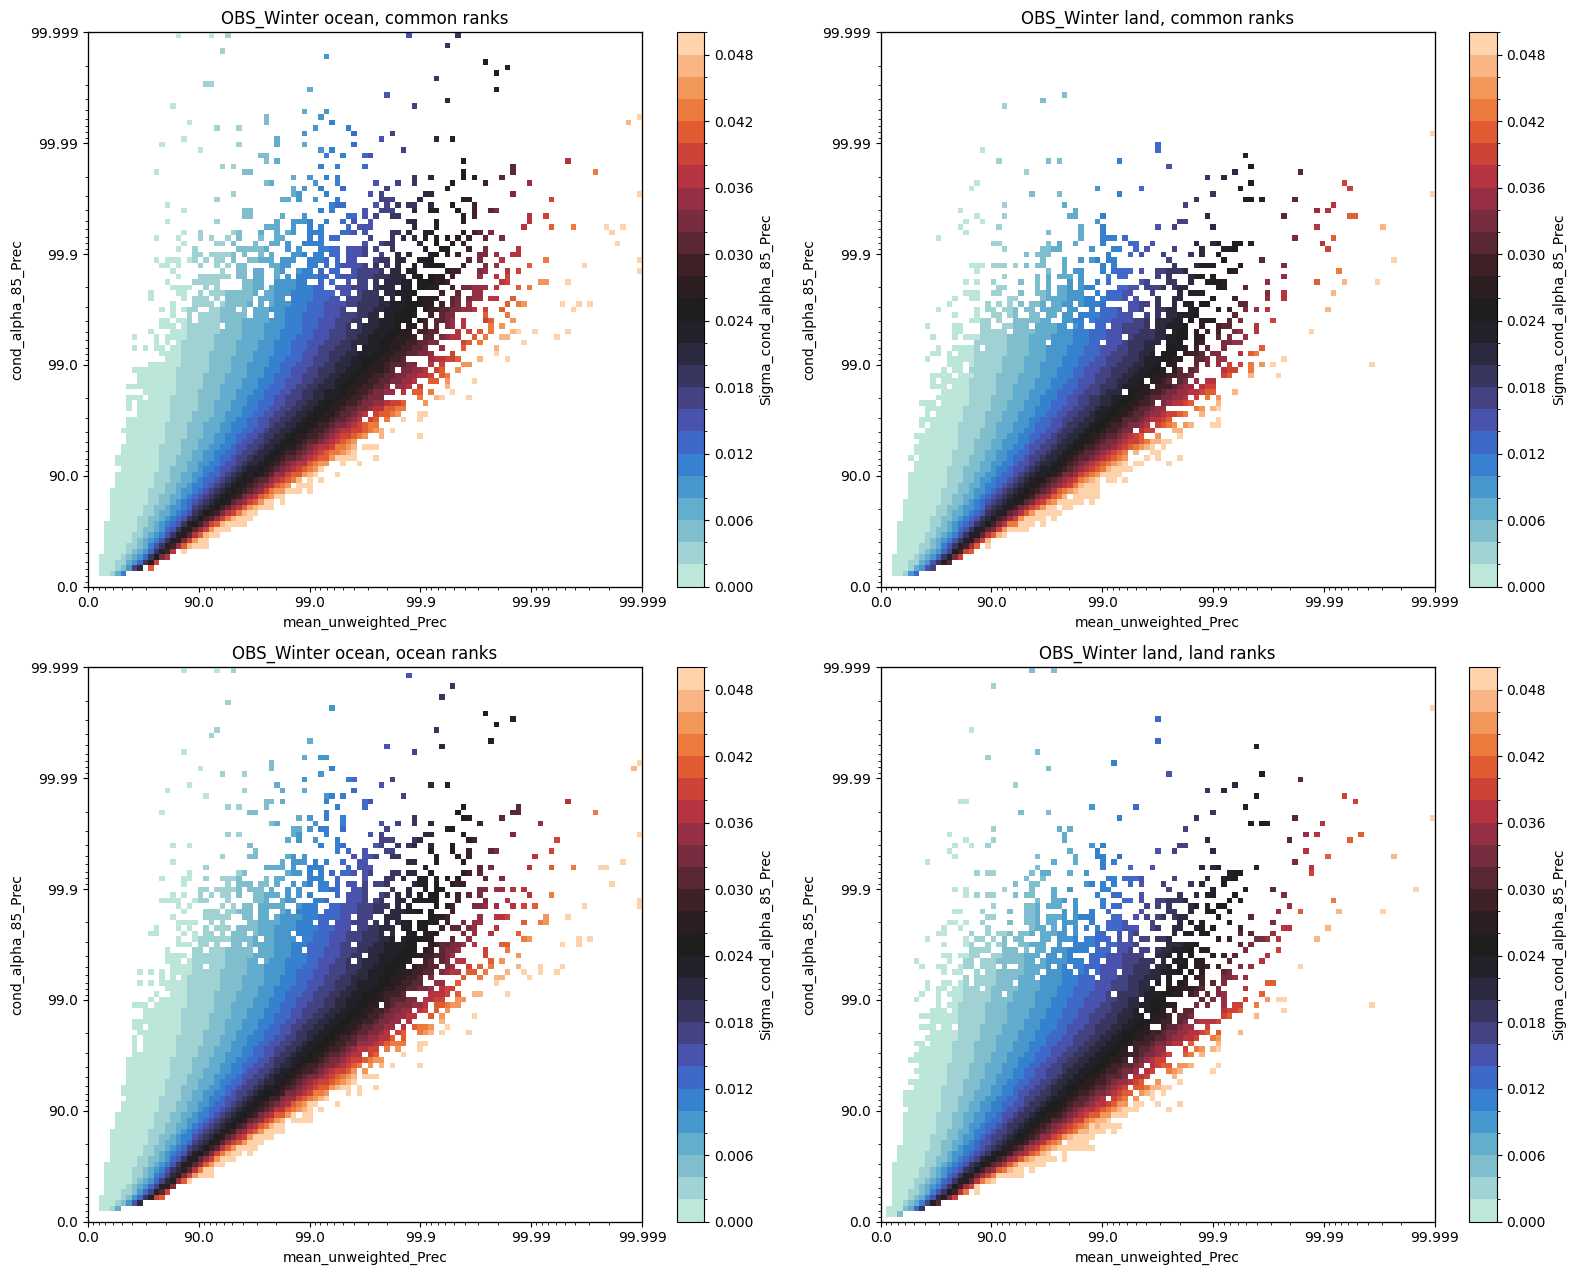

In [2]:
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_winter = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "all")
jd_winter_ocean = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "ocean")
jd_winter_land = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "land")

fig, axs = plt.subplots(2, 2, figsize = (16, 12.85))
model_name = jd_winter.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

_, _, _, sigma_density_common_obs_winter_ocean = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " ocean, common ranks" , mask = "ocean", cmap = cmap, norm = norm, fig = fig, ax = axs[0,0])
_, _, _, sigma_density_common_obs_winter_land = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " land, common ranks", mask = "land", cmap = cmap, norm = norm, fig = fig, ax = axs[0,1])
_, _, _, sigma_density_ocean_obs_winter_ocean = jd_winter_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " ocean, ocean ranks", mask = "ocean", cmap = cmap, norm = norm, fig = fig, ax = axs[1,0])
_, _, _, sigma_density_land_obs_winter_land = jd_winter_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " land, land ranks", mask = "land", cmap = cmap, norm = norm, fig = fig, ax = axs[1,1])
plt.tight_layout()

Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy
Simple distribs loaded
Overwrite set to false so loading basics attributes from .npy


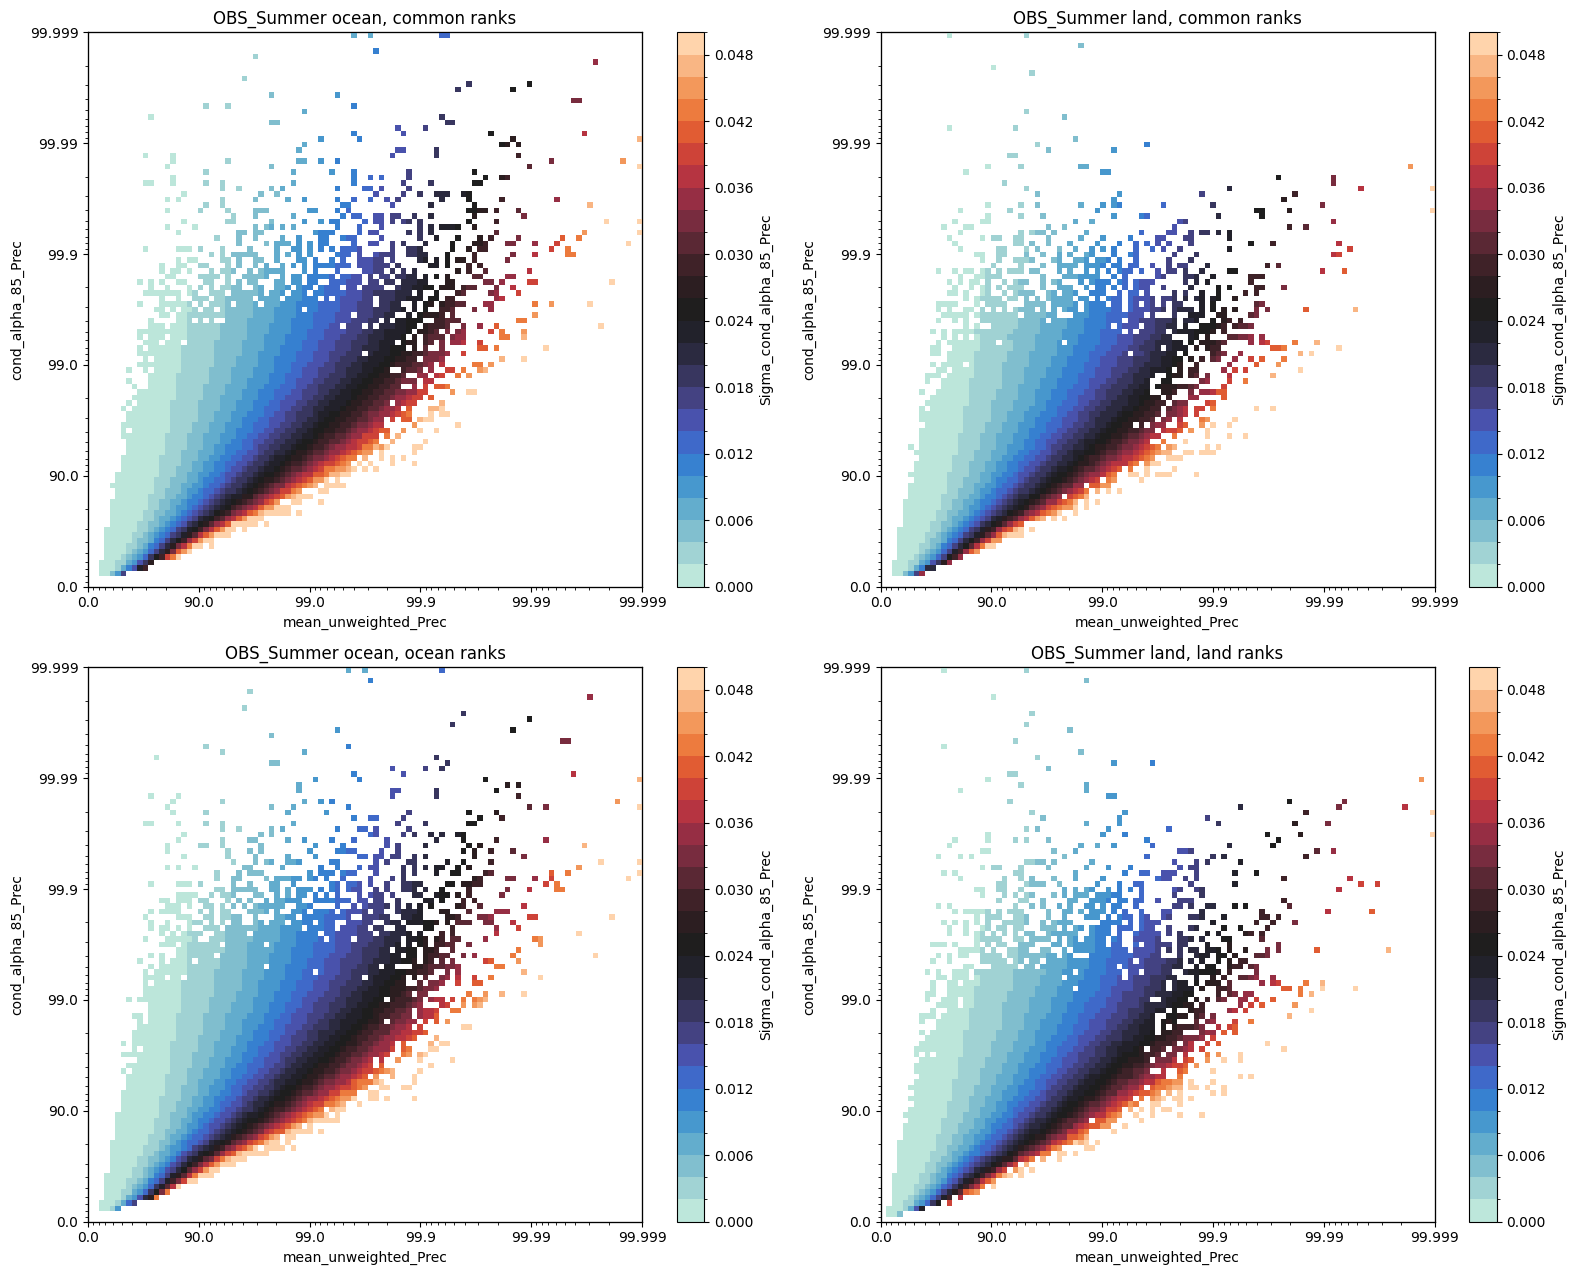

In [3]:
settings_path = 'settings/obs_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_summer = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "all")
jd_summer_ocean = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "ocean")
jd_summer_land = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20,  nd=5, overwrite = False, dist_mask = "land")

fig, axs = plt.subplots(2, 2, figsize = (16, 12.85))
model_name = jd_summer.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

_, _, _, sigma_density_common_obs_summer_ocean = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " ocean, common ranks" , mask = "ocean", cmap = cmap, norm = norm, fig = fig, ax = axs[0,0])
_, _, _, sigma_density_common_obs_summer_land = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " land, common ranks", mask = "land", cmap = cmap, norm = norm, fig = fig, ax = axs[0,1])
_, _, _, sigma_density_ocean_obs_summer_ocean = jd_summer_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " ocean, ocean ranks", mask = "ocean", cmap = cmap, norm = norm, fig = fig, ax = axs[1,0])
_, _, _, sigma_density_land_obs_summer_land = jd_summer_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', title=model_name + " land, land ranks", mask = "land", cmap = cmap, norm = norm, fig = fig, ax = axs[1,1])
plt.tight_layout()

## 3d plot here

In [4]:
def apply_mask(data, mask, mask_compat):
    shape = np.shape(data)
    mask = mask_compat & mask  # join mask
    
    fdata, fmask = data.reshape(-1), mask.reshape(-1)
    fdata[~fmask] = np.nan
    rdata = fdata.reshape(shape)
    return rdata


# Objective function to minimize
def objective(coeff, data, data2):
    # Reshape to 1D and remove NaNs
    data_flat = data.reshape(-1)
    data2_flat = data2.reshape(-1)

    # Remove NaNs
    valid_indices = ~np.isnan(data_flat) & ~np.isnan(data2_flat)
    data_flat = data_flat[valid_indices]
    data2_flat = data2_flat[valid_indices]

    # Apply the coefficient to data2
    scaled_data2 = coeff * data2_flat
    
    # Calculate the Frobenius norm
    norm = np.linalg.norm(data_flat - scaled_data2)
    return norm

In [8]:
import numpy as np
from scipy.optimize import minimize
import plotly.graph_objects as go

# Example 2D arrays
# Assuming sigma_density_obs_winter and sigma_density_model_winter are defined
data = np.copy(sigma_density_land_obs_winter_land.T)
data2 = np.copy(sigma_density_land_obs_summer_land.T)

# Mask creation
mask_compat = (~np.isnan(data)) & (~np.isnan(data2))
mask_dd = np.triu(np.ones(np.shape(data), dtype=bool))
mask_km = np.triu(np.ones(np.shape(data), dtype=bool)).T

def apply_mask(data, mask, mask_compat=mask_compat):
    shape = np.shape(data)
    mask = mask_compat & mask  # join mask
    
    fdata, fmask = data.reshape(-1), mask.reshape(-1)
    fdata[~fmask] = np.nan
    rdata = fdata.reshape(shape)
    return rdata

if False : 
    n_rank = 40
    n_rank_2 = -1
else : 
    n_rank = 20
    n_rank_2 = 40
    
coeff_dd = 4
coeff_km = 3

# Apply masks
data_km = apply_mask(data, mask_km)[n_rank:n_rank_2, n_rank:n_rank_2]
data2_km = apply_mask(data2, mask_km)[n_rank:n_rank_2, n_rank:n_rank_2]

data_dd = apply_mask(data, mask_dd)[n_rank:n_rank_2, n_rank:n_rank_2]
data2_dd = apply_mask(data2, mask_dd)[n_rank:n_rank_2, n_rank:n_rank_2]

# Debugging: Check for NaN values
print("Number of NaNs in data_dd:", np.isnan(data_dd).sum())
print("Number of NaNs in data2_dd:", np.isnan(data2_dd).sum())
print("Number of NaNs in data_km:", np.isnan(data_km).sum())
print("Number of NaNs in data2_km:", np.isnan(data2_km).sum())

# Objective function to minimize
def objective(coeff, data, data2):
    # Reshape to 1D and remove NaNs
    data_flat = data.reshape(-1)
    data2_flat = data2.reshape(-1)

    # Remove NaNs
    valid_indices = ~np.isnan(data_flat) & ~np.isnan(data2_flat)
    data_flat = data_flat[valid_indices]
    data2_flat = data2_flat[valid_indices]

    # Apply the coefficient to data2
    scaled_data2 = coeff * data2_flat
    
    # Calculate the Frobenius norm
    norm = np.linalg.norm(data_flat - scaled_data2)
    return norm

# Add diagnostic print to check initial norms
initial_norm_dd = objective(coeff_dd, data_dd, data2_dd)
initial_norm_km = objective(coeff_km, data_km, data2_km)

print(f"Initial Frobenius Norm (dd): {initial_norm_dd}")
print(f"Initial Frobenius Norm (km): {initial_norm_km}")

# Optimization for dd coefficient
result_dd = minimize(objective, coeff_dd, args=(data_dd, data2_dd), method='L-BFGS-B', bounds=[(0, None)])
optimal_coeff_dd = result_dd.x[0]

# Optimization for km coefficient
result_km = minimize(objective, coeff_km, args=(data_km, data2_km), method='L-BFGS-B', bounds=[(0, None)])
optimal_coeff_km = result_km.x[0]

# Add diagnostic print to check optimized norms
optimized_norm_dd = objective(optimal_coeff_dd, data_dd, data2_dd)
optimized_norm_km = objective(optimal_coeff_km, data_km, data2_km)

print(f"Optimized Frobenius Norm (dd): {optimized_norm_dd}")
print(f"Optimized Frobenius Norm (km): {optimized_norm_km}")

# Check optimization results
print("Optimization Success (dd):", result_dd.success)
print("Optimization Message (dd):", result_dd.message)
print("Optimization Success (km):", result_km.success)
print("Optimization Message (km):", result_km.message)

# Applying the optimal coefficients
optimized_data2_dd = optimal_coeff_dd * data2_dd
optimized_data2_km = optimal_coeff_km * data2_km

# Print the results
print("Optimal Coefficient for dd:", optimal_coeff_dd)
print("Optimal Coefficient for km:", optimal_coeff_km)

# Plot the results using Plotly
x = np.arange(data.shape[1])
y = np.arange(data.shape[0])

fig = go.Figure(data=[go.Surface(z=data_dd, x=x, y=y, colorscale='Viridis')])

fig.add_trace(go.Surface(z=optimized_data2_dd, x=x, y=y, colorscale='Plasma', name='Surface 2', opacity=0.8))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='P'),
        yaxis=dict(title=r"P_{\alpha}"),
        zaxis=dict(title=r"\sigma_{\alpha}")
    ),
    title='Interactive 3D Surface Plot with Optimized Coefficients',
    autosize=True,
    width=700,
    height=700
)

fig.show()


Number of NaNs in data_dd: 190
Number of NaNs in data2_dd: 190
Number of NaNs in data_km: 190
Number of NaNs in data2_km: 190
Initial Frobenius Norm (dd): 0.7001601081808296
Initial Frobenius Norm (km): 0.20041080771597766
Optimized Frobenius Norm (dd): 0.008571275855228568
Optimized Frobenius Norm (km): 0.005570882013685123
Optimization Success (dd): True
Optimization Message (dd): CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization Success (km): True
Optimization Message (km): CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimal Coefficient for dd: 1.211216061142236
Optimal Coefficient for km: 1.2734102829995435


## whats up in these two months simple distrib

In [9]:
settings_paths = [
    "settings/obs_summer_30d.yaml", 
    "settings/obs_winter_30d.yaml"
    ] 
 
hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
lm = grs[0].get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]
## extreme distribs
# jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
#         nbpd = 20,  nd=5, overwrite = True, dist_mask = False) for gr in grs]

# jds_ocean = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
#         nbpd = 20,  nd=5, overwrite = True, dist_mask = ocean) for gr in grs]

# jds_land = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
#         nbpd = 20,  nd=5, overwrite = True, dist_mask = ~ocean) for gr in grs]

## linear distrib
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = False, dist_bintype = "invlogQ") for gr in grs]

jds_ocean = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = "ocean", dist_bintype = "invlogQ") for gr in grs]

jds_land = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = "land", dist_bintype = "invlogQ") for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


(0.0, 62.6018220031977)

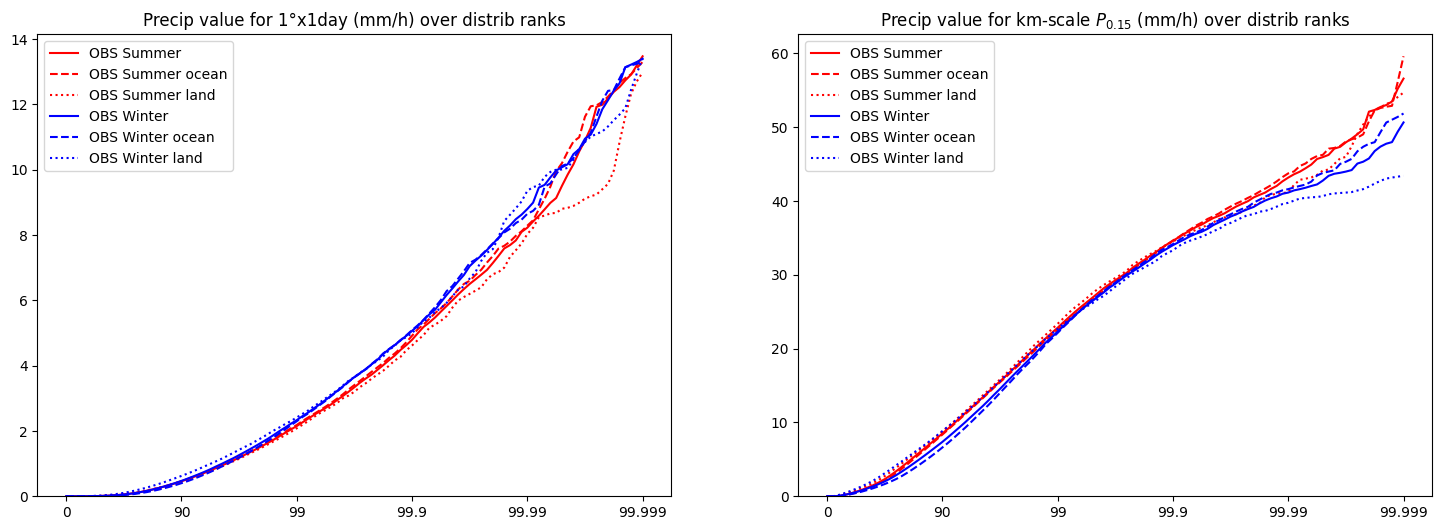

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (18, 6))
# plt.suptitle("ocean : '--' ; land : '..', ocean+land : solid")
colors = ["red", "blue"]


for idx, (jd, jd_ocean, jd_land) in enumerate(zip(jds, jds_ocean, jds_land)): 
    model = jd.name.split("_")[0]+" "+jd.name.split("_")[1]
    color = colors[idx]
    x = np.arange(len(jd.dist1.ranks))
    axs[0].plot(x, jd.dist1.percentiles, label = model, color = color)
    axs[1].plot(x, jd.dist2.percentiles, label = model, color = color)

    axs[0].plot(x, jd_ocean.dist1.percentiles,label = model+" ocean" , color = color, linestyle = '--')
    axs[1].plot(x, jd_ocean.dist2.percentiles, label = model+" ocean", color = color, linestyle = '--')

    axs[0].plot(x, jd_land.dist1.percentiles, color = color, label = model+" land", linestyle = 'dotted')
    axs[1].plot(x, jd_land.dist2.percentiles, color = color, label = model+" land", linestyle = 'dotted')

axs[0].legend()
axs[1].legend()

# axs[0].set_xticks(x[::10], np.round(jd.dist1.ranks[::10]))
# axs[1].set_xticks(x[::10], np.round(jd.dist2.ranks[::10]))

ranks = np.array([ "0", "90", "99", "99.9", "99.99", "99.999"])
axs[0].set_xticks(x[::20])
axs[1].set_xticks(x[::20])

axs[0].set_xticklabels(ranks)
axs[1].set_xticklabels(ranks)


axs[0].set_title("Precip value for 1°x1day (mm/h) over distrib ranks")
axs[1].set_title("Precip value for km-scale $P_{0.15}$ (mm/h) over distrib ranks")

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)

# axs[0].set_yscale('log')

## compute sigma015bysigma100

In [6]:
### WINTER + SUMMER### No Obs
settings_paths = [
  "settings/arpege_winter_30d.yaml", 
  "settings/arpege_summer_30d.yaml", 

  "settings/ifs_winter_30d.yaml" , 
  "settings/ifs_summer_30d.yaml" , 
  
  "settings/mpas_winter_30d.yaml", 
  "settings/mpas_summer_30d.yaml", 

  "settings/obs_winter_30d.yaml",
  "settings/obs_summer_30d.yaml",

  "settings/screamv1_winter_30d.yaml",
  "settings/screamv1_summer_30d.yaml", 
 
  "settings/sam_winter_30d.yaml", 
  "settings/sam_summer_30d.yaml", 

  "settings/um_winter_30d.yaml",
  "settings/um_summer_30d.yaml",

  "settings/xshield_winter_30d.yaml" , 
  "settings/fv3_summer_30d.yaml", 
  
  "settings/geos_winter_30d.yaml", 
  "settings/grist_winter_30d.yaml", 
  "settings/nicam_summer_30d.yaml", 
               ]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = False) for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SAM_Winter_lowRes_Tropics/va

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning:

invalid value encountered in divide



Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recom

In [7]:
for jd in jds : 
    jd.prec["Sigma_cond_alpha_85_by_Sigma_cond_alpha_00_Prec"] = jd.prec["Sigma_cond_alpha_85_Prec"]/jd.prec["Sigma_cond_alpha_00_Prec"]


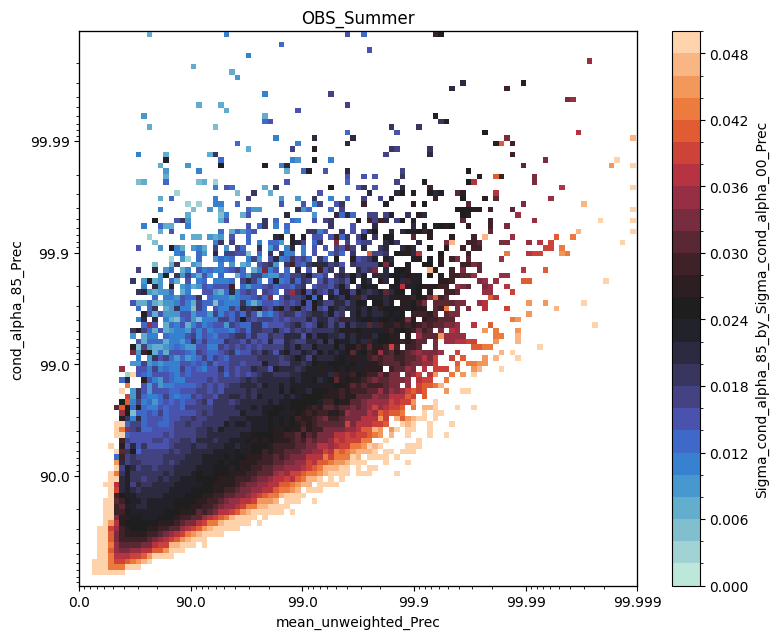

In [8]:
jd = jds[7]
fig, ax = plt.subplots(1, 1, figsize = (9, 7.2))
model_name = jd.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar, ax_show, ratio_sigma_density_obs_winter = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85_by_Sigma_cond_alpha_00', title=model_name , mask = "all", cmap = cmap, norm = norm, fig = fig, ax = ax) #+  r" $\sigma_{0.15}$"


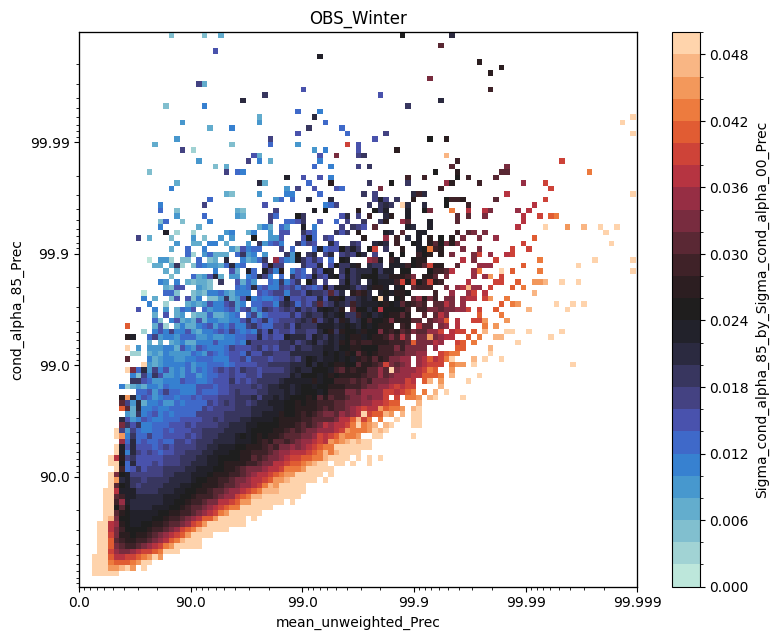

In [9]:
jd = jds[6]
fig, ax = plt.subplots(1, 1, figsize = (9, 7.2))
model_name = "OBS_Winter"
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar, ax_show, ratio_sigma_density_obs_winter = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85_by_Sigma_cond_alpha_00', title=model_name , mask = "all", cmap = cmap, norm = norm, fig = fig, ax = ax) #+  r" $\sigma_{0.15}$"
